# Hybrid quantum-classical auto encoder 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ===================================================================================
#                       Create Data
# ===================================================================================

num_train = 100
num_test = 20
len_vector = 3

np.random.seed(1)
x_train = torch.tensor(np.random.rand(num_train, len_vector), dtype=torch.float32)
x_test = torch.tensor(np.random.rand(num_test, len_vector), dtype=torch.float32)

In [3]:
# ===================================================================================
#                       Classical Layers using PyTorch Sequential
# ===================================================================================

# Define first layer, hidden layers, and output layer with the output of two neurons

model = nn.Sequential(
    nn.Linear(3, 5),
    nn.ELU(),
    nn.Linear(5, 5),
    nn.ELU(),
    nn.Linear(5, 5),
    nn.ELU(),
    nn.Linear(5, 5),
    nn.ELU(),
    nn.Linear(5, 5),
    nn.ELU(),
    nn.Linear(5, 5),
    nn.ELU(),
    nn.Linear(5, 2),
    nn.ELU()
)

In [4]:
# ===================================================================================
#                                Quantum Layer
# ===================================================================================

num_modes = 1
num_basis = 3

dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=num_basis)

class QuantumLayer(nn.Module):
    def __init__(self, num_layers, num_modes):
        super().__init__()
        self.num_layers = num_layers
        self.num_modes = num_modes
        self.weights = nn.Parameter(torch.randn(num_layers, 5 * num_modes))

    def forward(self, x):
        def q_layer(v):
            qml.Rotation(v[0], wires=0)
            qml.Squeezing(v[1], 0.0, wires=0)
            qml.Rotation(v[2], wires=0)
            qml.Displacement(v[3], 0.0, wires=0)
            qml.Kerr(v[4], wires=0)
        
        @qml.qnode(dev, interface='torch')
        def quantum_nn(inputs, weights):
            # Assuming inputs is a tensor with shape [batch_size, 2]
            for i in range(inputs.shape[0]):
                qml.Displacement(inputs[i, 0].item(), inputs[i, 1].item(), wires=0)
            for v in weights:
                q_layer(v)
            return qml.probs(wires=0)
        
        # Clone and detach to ensure compatibility with PyTorch's computational graph
        x = x.clone().detach().requires_grad_(True)
        return quantum_nn(x, self.weights).float()

In [5]:
# ===================================================================================
#                             Hybrid Model
# ===================================================================================

num_layers = 25
num_modes = 1

qlayer = QuantumLayer(num_layers, num_modes)
model.add_module("QuantumLayer", qlayer)

In [6]:
# ===================================================================================
#                                    Training
# ===================================================================================

opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()

# Initialize lists to store the history
loss_history = []
accuracy_history = []

# Define a function to calculate accuracy (replace this with your accuracy calculation method)
def calculate_accuracy(y_pred, y_true):
    # Dummy accuracy calculation: replace with your actual accuracy calculation
    # For example, you could define accuracy as the percentage of predictions within a certain range of the actual values
    return torch.mean((y_pred - y_true).abs() / y_true.abs()).item()

for epoch in range(10):
    opt.zero_grad()
    output = model(x_train)
    loss = loss_func(output, x_train)
    loss.backward()
    opt.step()
    accuracy = calculate_accuracy(output, x_train)
    
    # Append loss and accuracy to their respective lists
    loss_history.append(loss.item())
    accuracy_history.append(accuracy)
    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}")



/Users/rohitganti/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 1, Loss: 0.3473872244358063, Accuracy: 1.0
Epoch 2, Loss: 0.3473872244358063, Accuracy: 1.0
Epoch 3, Loss: 0.3473872244358063, Accuracy: 1.0
Epoch 4, Loss: 0.3473872244358063, Accuracy: 1.0
Epoch 5, Loss: 0.3473872244358063, Accuracy: 1.0
Epoch 6, Loss: 0.3473872244358063, Accuracy: 1.0
Epoch 7, Loss: 0.3473872244358063, Accuracy: 1.0
Epoch 8, Loss: 0.3473872244358063, Accuracy: 1.0
Epoch 9, Loss: 0.3473872244358063, Accuracy: 1.0
Epoch 10, Loss: 0.3473872244358063, Accuracy: 1.0


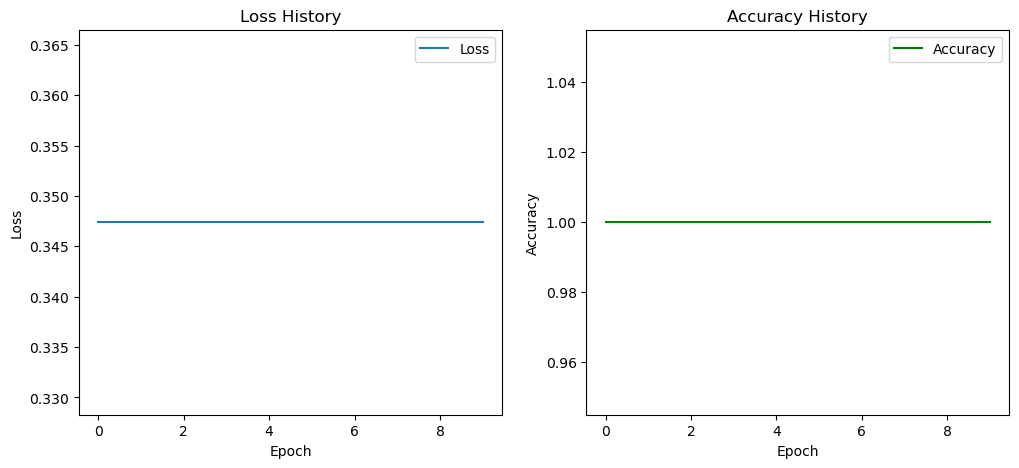

In [7]:
# Plotting
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy', color='green')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [11]:
from qiskit_nature.second_q.drivers import PySCFDriver
import torch
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto-3g")
problem = driver.run()
hamiltonian = problem.hamiltonian
coefficients = hamiltonian.electronic_integrals
inputs= coefficients.alpha
print(type(coefficients))
print(coefficients.alpha)

<class 'qiskit_nature.second_q.operators.electronic_integrals.ElectronicIntegrals'>
Polynomial Tensor
 "+-":
array([[-1.25633907e+00, -1.37083854e-17],
       [-3.92720783e-17, -4.71896007e-01]])
 "++--":
array([6.75710155e-01, 8.69283836e-17, 1.80931200e-01, 6.64581730e-01,
       2.25343262e-16, 6.98573723e-01])


In [22]:
torch.tensor(inputs.tensor, dtype=torch.float32)

TypeError: must be real number, not method

In [17]:
inputs.tensor

<bound method PolynomialTensor.tensor of PolynomialTensor({'+-': array([[-1.25633907e+00, -1.37083854e-17],
       [-3.92720783e-17, -4.71896007e-01]]), '++--': array([6.75710155e-01, 8.69283836e-17, 1.80931200e-01, 6.64581730e-01,
       2.25343262e-16, 6.98573723e-01])})>

ValuesView(PolynomialTensor({'+-': array([[-1.25633907e+00, -1.37083854e-17],
       [-3.92720783e-17, -4.71896007e-01]]), '++--': array([6.75710155e-01, 8.69283836e-17, 1.80931200e-01, 6.64581730e-01,
       2.25343262e-16, 6.98573723e-01])}))

In [33]:
ss=hamiltonian.second_q_op()

In [37]:
dis= dict(ss)

In [43]:
arrs = []
for elements in dis:
    arrs.append(dis[elements])
    print(dis[elements])

-1.25633907300325
-0.47189600728114184
-1.25633907300325
-0.47189600728114184
0.3378550774017583
0.3322908651276482
0.3378550774017583
0.3322908651276482
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.3322908651276482
0.34928686136600906
0.3322908651276482
0.34928686136600906
0.3378550774017583
0.3322908651276482
0.3378550774017583
0.3322908651276482
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.09046559989211572
0.3322908651276482
0.34928686136600906
0.3322908651276482
0.34928686136600906


36